# トピックモデル(Latent Dirichlet Allocation, LDA)の実装
---
pythonのgensim(トピックモデルのライブラリ）を使って簡単な実装をしてみる．  
目的は**顧客のクラスタを発見し，クラスタごとの購入傾向を観察する**こと．  
今回は，各顧客が購入した商品の*item_category_1の情報だけ*使用して簡単な分析をしてみた．  

### 目次  
- 前処理  
 - テーブルの準備  
 - BOW表現に変換
 - 辞書の作成
 - コーパスの作成　
- 実行部分
 - LDAの実行
 - トピック（クラスタ）の数を推定
 - トピックごとの距離
 - トピックごとの傾向

## 前処理
---
実行の前に必要な前処理をしておく．

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import gensim
from gensim import corpora
import time

まずは必要なテーブルを作成する(order, detail_order, itemのテーブルから必要な列のみ抽出）

In [2]:
order = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/order.csv")
detail = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/order_detail.csv")
item = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/item.csv")

In [3]:
df = pd.merge(pd.merge(order, detail, on='order_id', how='left'), item, on='item_id', how='left')[['customer_id', 'item_category_1']].dropna()

作成したテーブルはこんな感じ．

In [4]:
print(u'unique user数 : ', len(set(df.customer_id)), u'人')
print(u'カテゴリの種類 : ', len(set(df.item_category_1)), u'種類')
df.head(50)

unique user数 :  101491 人
カテゴリの種類 :  25 種類


,customer_id,item_category_1
0,5537,雑貨/ホビー/スポーツ
1,5537,雑貨/ホビー/スポーツ
2,5537,雑貨/ホビー/スポーツ
3,5537,雑貨/ホビー/スポーツ
4,5537,雑貨/ホビー/スポーツ
5,5537,雑貨/ホビー/スポーツ
6,5537,雑貨/ホビー/スポーツ
7,5537,雑貨/ホビー/スポーツ
8,5537,雑貨/ホビー/スポーツ
9,5537,雑貨/ホビー/スポーツ


customer_idを0から再割り当てする（別にしなくても良いけど番号ばバラバラだと気持ち悪いので）

In [5]:
unique_customer_id = set(df.customer_id)
dict_customer_id = dict(zip(list(unique_customer_id), [i for i in range(len(unique_customer_id))]))

df.customer_id= df.customer_id.apply(lambda x: dict_customer_id[x])
df.sort(columns='customer_id').head(50)

/Users/TakayukiYagi/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,customer_id,item_category_1
3588130,0,バッグ
1598761,0,シューズ
1598760,0,シューズ
1598759,0,シューズ
1598758,0,シューズ
1598757,0,シューズ
1598756,0,シューズ
1598755,0,シューズ
1598754,0,シューズ
1598752,0,雑貨/ホビー/スポーツ


BOW(bag-of-words)表現に変換する．  
各ユーザがどの商品を購入したのかを**重複あり**で表現する．
  
bows = [[user1が購入した商品], [user2が購入した商品], ..., [userNが購入した商品]]

In [6]:
bows = [[] for i in range(len(unique_customer_id))]
for (c, i) in df.as_matrix():
    bows[c].append(str(i))

# user1 と user2のbowを表示
print(bows[0:2])

[['シューズ', 'シューズ', 'ジャケット/アウター', 'ジャケット/アウター', 'トップス', 'トップス', 'トップス', 'トップス', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'ジャケット/アウター', '雑貨/ホビー/スポーツ', '雑貨/ホビー/スポーツ', '雑貨/ホビー/スポーツ', '雑貨/ホビー/スポーツ', '雑貨/ホビー/スポーツ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'シューズ', 'トップス', 'トップス', 'トップス', 'バッグ', 'バッグ', 'トップス', 'バッグ', 'バッグ', 'バッグ'], ['帽子', '帽子', '帽子', '帽子', '帽子', '帽子', '帽子', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダーウェア', 'アンダー

購入商品が10未満の人を除外しておく

In [7]:
bows = list(filter(lambda x: len(x)>10, bows))

カテゴリー名を記号と対応付けさせた**辞書を用意**する．

In [8]:
dictionary = corpora.Dictionary(bows)
print(dictionary)
print('')
print(dictionary.token2id)

Dictionary(25 unique tokens: ['ファッション雑貨', '財布/小物', '雑貨/ホビー/スポーツ', 'レッグウェア', 'シューズ']...)

{'ファッション雑貨': 10, '財布/小物': 16, '雑貨/ホビー/スポーツ': 0, 'レッグウェア': 14, 'シューズ': 2, 'コスメ/香水': 21, 'マタニティ・ベビー': 15, 'スーツ/ネクタイ': 22, 'ヘアアクセサリー': 18, '食器/キッチン': 23, 'スカート': 7, '時計': 11, 'その他': 12, '帽子': 8, 'パンツ': 6, 'ワンピース': 9, 'インテリア': 20, 'バッグ': 1, '水着/着物・浴衣': 19, '音楽/本・雑誌': 17, 'ジャケット/アウター': 4, 'オールインワン・サロペット': 24, 'アクセサリー': 13, 'アンダーウェア': 3, 'トップス': 5}


顧客ごとにどの商品を何回購入したのかを示す**コーパスを用意**する．

In [9]:
corpus = [dictionary.doc2bow(bow) for bow in bows]
print(corpus[0:3])

[[(0, 5), (1, 5), (2, 16), (3, 10), (4, 3), (5, 8)], [(0, 2), (1, 3), (3, 54), (5, 1), (6, 10), (7, 5), (8, 9), (9, 2)], [(1, 3), (2, 23), (4, 10), (5, 84), (6, 4), (10, 2), (11, 2), (12, 2), (13, 3), (14, 6)]]


## LDAの実行
---

学習データと試験データに分割する．

In [10]:
p = int(len(corpus)*0.6)
corpus_train = corpus[0:p]
corpus_test = corpus[p:]

LDAを異なるトピック数(1,3,7,10,15,30)で実行する．（適切なトピックするを見つけたい）  
評価基準 (perplexity)が低いほど良い．

In [11]:
num_of_topics = [1, 3, 5, 7, 10, 15, 30, 50]
perplex_list = []

def calc_perplexity(m, c):
    return np.exp(-m.log_perplexity(c))

for k in num_of_topics:
    print("topic_number : %d" %k)
    start_time = time.time()
    
    # モデル実行
    model = gensim.models.ldamodel.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=k)
    
    # 経過時間表示
    print("Elapsed time : %s" %(time.time() - start_time))
    
    # Perplexity(評価基準)の表示
    perplexity =  calc_perplexity(model, corpus_test)
    print("Perplexity : %s" %perplexity)
    perplex_list.append(perplexity)
    
    print("")
    

topic_number : 1
Elapsed time : 5.793921947479248
Perplexity : 8.37193519154

topic_number : 3
Elapsed time : 28.08594298362732
Perplexity : 6.74289688683

topic_number : 5
Elapsed time : 30.95033288002014
Perplexity : 5.45624794

topic_number : 7
Elapsed time : 40.23318791389465
Perplexity : 5.08423187349

topic_number : 10
Elapsed time : 30.30671215057373
Perplexity : 4.72695542602

topic_number : 15
Elapsed time : 37.195098876953125
Perplexity : 4.59674833701

topic_number : 30
Elapsed time : 33.50134301185608
Perplexity : 4.48655197772

topic_number : 50
Elapsed time : 48.260358810424805
Perplexity : 4.61736937758



横軸にトピック数，縦軸にperplexityをとってグラフにプロットする．
perplexityは低い方が良いが，トピック数(顧客のクラスタ数）が多すぎると解釈が難しくなるので10を採用．

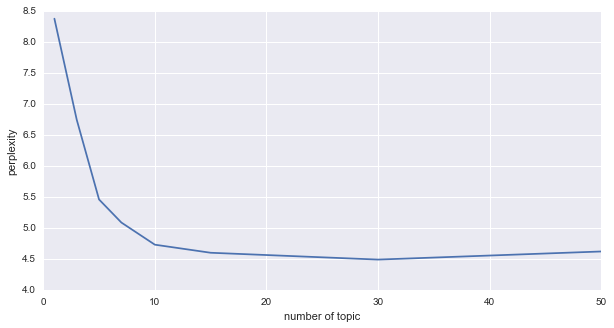

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(num_of_topics, perplex_list)
plt.ylabel("perplexity")
plt.xlabel("number of topic")

トピック数（クラスタ数）が10のモデルを再計算する．

In [13]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=10)

トピックごとの距離を計算する．（距離が遠い方が良い）  
けど，割と近いから良い結果が出てないっぽい．（全体的に色が濃い（近い））
(※擬距離を求めているので対称性を満たさないことに注意）

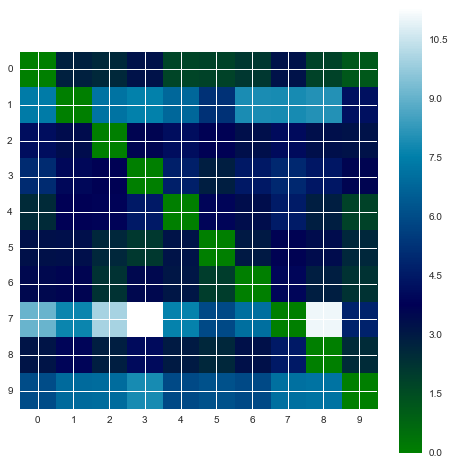

In [14]:
def calc_topic_distances(model, topic):
    
    def kldiv(p, q):
        distance = np.sum(p * np.log(p / q))
        return distance
    
    t = model.state.get_lambda()
    for i in range(len(t)):
        t[i] = t[i] / sum(t[i])

    base = t[topic]
    distances = [(i_p[0], kldiv(base, i_p[1])) for i_p in enumerate(t) if i_p[0] != topic]
    return distances

def plot_distance_matrix(model):
    
    mt = []
    for i in range(model.num_topics):
        d = calc_topic_distances(model, i)
        d.insert(i, (i, 0)) 
        d = [_d[1] for _d in d]
        mt.append(d)

    mt = np.array(mt)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(mt, interpolation="nearest", cmap=plt.cm.ocean)
    plt.yticks(range(mt.shape[0]))
    plt.xticks(range(mt.shape[1]))
    plt.colorbar()
    plt.show()

plot_distance_matrix(model)

トピック（顧客の集団）ごとの好みを表示．  
解釈むずかしい〜〜 (でもなんとなく分かれてるのかな...??)

In [15]:
for k in range(model.num_topics):
    print("-----  topic %d  -----" %k)
    print("")
    res = model.show_topic(k, topn=5)
    for (text, p) in res:
        print(str(round(p*100,1)).rjust(4),"%   ", text)
    print("")

-----  topic 0  -----

92.8 %    トップス
 2.5 %    パンツ
 1.1 %    シューズ
 0.8 %    バッグ
 0.8 %    ジャケット/アウター

-----  topic 1  -----

87.0 %    レッグウェア
 4.6 %    トップス
 1.3 %    バッグ
 1.2 %    シューズ
 0.9 %    財布/小物

-----  topic 2  -----

46.2 %    ワンピース
20.4 %    帽子
 5.6 %    トップス
 5.5 %    オールインワン・サロペット
 5.4 %    シューズ

-----  topic 3  -----

21.2 %    財布/小物
19.0 %    バッグ
16.1 %    インテリア
14.1 %    雑貨/ホビー/スポーツ
 9.3 %    食器/キッチン

-----  topic 4  -----

79.8 %    パンツ
12.7 %    トップス
 2.0 %    シューズ
 1.7 %    ジャケット/アウター
 1.0 %    バッグ

-----  topic 5  -----

33.8 %    アクセサリー
20.2 %    ファッション雑貨
12.2 %    トップス
11.3 %    ヘアアクセサリー
 7.2 %    シューズ

-----  topic 6  -----

84.3 %    シューズ
 8.7 %    トップス
 2.5 %    バッグ
 1.1 %    パンツ
 0.5 %    ジャケット/アウター

-----  topic 7  -----

92.3 %    アンダーウェア
 3.0 %    トップス
 0.9 %    シューズ
 0.9 %    スカート
 0.7 %    バッグ

-----  topic 8  -----

53.1 %    ジャケット/アウター
20.1 %    スカート
11.9 %    トップス
 7.6 %    バッグ
 2.4 %    シューズ

-----  topic 9  -----

54.3 %    その他
24.4 %    トップス
 6.8 % 

## 感想
---
初めてなのでうまくいったのか，いってないのかよく分からない．  
次は
- カテゴリの区分を変更したり  
- 補助情報とか時系列情報  
を入れてみようかな